# **Exploratory Data Analysis (EDA) – Raw Movie Plots Dataset**

This notebook focuses on the exploratory analysis of the raw dataset, providing insights into structure, missing values, and data quality issues prior to the ETL phase.

**1. Notebook setup and autoreload**

In [6]:
# --- Notebook setup and autoreload configuration ---
# This cell runs the initial setup script and enables the autoreload extension.
# The autoreload feature ensures that updates made to imported modules (e.g., in src/)
# are automatically reloaded without restarting the kernel.
%run notebook_setup.py

%load_ext autoreload

%autoreload 2

CWD: /home/ilfn/datascience/workspace/rag-movie-plots/notebooks
PYTHONPATH: ['/home/ilfn/datascience/workspace/rag-movie-plots/notebooks', '/home/ilfn/datascience/workspace/rag-movie-plots/src/backend', '/home/ilfn/datascience/workspace/rag-movie-plots/src']
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**2. Import dependencies and configuration**

In [ ]:
from pathlib import Path
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt

from config import CLEANING_CONFIG

**3. Data Loading and Initial Analysis**

In this section, we load the raw dataset containing movie plot summaries. The goal is to verify the structure, data types, and overall consistency before applying any cleaning procedures.

In [8]:
pd.set_option('display.max_colwidth', 500)

RAW_DIR = Path("../data/raw")

csv_path = RAW_DIR / "wiki_movie_plots_deduped.csv"  
df = pd.read_csv(csv_path)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34886 entries, 0 to 34885
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Release Year      34886 non-null  int64 
 1   Title             34886 non-null  object
 2   Origin/Ethnicity  34886 non-null  object
 3   Director          34886 non-null  object
 4   Cast              33464 non-null  object
 5   Genre             34886 non-null  object
 6   Wiki Page         34886 non-null  object
 7   Plot              34886 non-null  object
dtypes: int64(1), object(7)
memory usage: 2.1+ MB


The dataset contains **34,886 entries** and **8 columns**, corresponding to basic metadata and plot information for each movie.

This confirms that the data was successfully loaded and will serve as the foundation for the preprocessing phase.

In [10]:
df.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Smashers,"A bartender is working at a saloon, serving drinks to customers. After he fills a stereotypically Irish man's bucket with beer, Carrie Nation and her followers burst inside. They assault the Irish man, pulling his hat over his eyes and then dumping the beer over his head. The group then begin wrecking the bar, smashing the fixtures, mirrors, and breaking the cash register. The bartender then sprays seltzer water in Nation's face before a group of policemen appear and order everybody to leave..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Light_of_the_Moon,"The moon, painted with a smiling face hangs over a park at night. A young couple walking past a fence learn on a railing and look up. The moon smiles. They embrace, and the moon's smile gets bigger. They then sit down on a bench by a tree. The moon's view is blocked, causing him to frown. In the last scene, the man fans the woman with his hat because the moon has left the sky and is perched over her shoulder to see everything better."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Presidents,"The film, just over a minute long, is composed of two shots. In the first, a girl sits at the base of an altar or tomb, her face hidden from the camera. At the center of the altar, a viewing portal displays the portraits of three U.S. Presidents—Abraham Lincoln, James A. Garfield, and William McKinley—each victims of assassination.\r\nIn the second shot, which runs just over eight seconds long, an assassin kneels feet of Lady Justice."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_the_Grizzly_King","Lasting just 61 seconds and consisting of two shots, the first shot is set in a wood during winter. The actor representing then vice-president Theodore Roosevelt enthusiastically hurries down a hillside towards a tree in the foreground. He falls once, but rights himself and cocks his rifle. Two other men, bearing signs reading ""His Photographer"" and ""His Press Agent"" respectively, follow him into the shot; the photographer sets up his camera. ""Teddy"" aims his rifle upward at the tree and fel..."
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Beanstalk_(1902_film),"The earliest known adaptation of the classic fairytale, this films shows Jack trading his cow for the beans, his mother forcing him to drop them in the front yard, and beig forced upstairs. As he sleeps, Jack is visited by a fairy who shows him glimpses of what will await him when he ascends the bean stalk. In this version, Jack is the son of a deposed king. When Jack wakes up, he finds the beanstalk has grown and he climbs to the top where he enters the giant's home. The giant finds Jack, w..."


**3.1. Analyzing Missing and Invalid Values**

Before cleaning, it is essential to understand the distribution of missing and invalid entries across all columns.

We consider not only `NaN` and empty strings but also textual placeholders such as `"unknown"`, `"unk"`, `"none"`, and `"null"`.

In [11]:
def analyze_missing_values(df: pd.DataFrame):
    """
    Analyze missing, unknown, or empty values in each column of a DataFrame.
    """
    
    # Define the set of values to be considered invalid (case-insensitive)
    invalid_values = {val.strip().lower() for val in CLEANING_CONFIG["invalid_values"]}

    summary = []
    total_rows = len(df)

    for col in df.columns:
        # Count NaN/None values
        n_missing = df[col].isna().sum()

        # Count string-based invalid values (case-insensitive)
        n_invalid = (
            df[col].astype(str).str.strip().str.lower().isin(invalid_values).sum()
        )

        # Total invalid values (NaN + invalid strings)
        total_invalid = n_missing + n_invalid

        # Percentage of invalid values
        perc_invalid = 100 * total_invalid / total_rows

        summary.append({
            "Column": col,
            "NaN/None": n_missing,
            "Invalid ('unknown', '')": n_invalid,
            "Total Invalid": total_invalid,
            "% Invalid": round(perc_invalid, 2)
        })

    summary_df = (
        pd.DataFrame(summary)
        .sort_values(by="% Invalid", ascending=False)
        .reset_index(drop=True)
    )

    return summary_df

In [12]:
result = analyze_missing_values(df)
print("Summary of missing and invalid values:\n")
display(result)

Summary of missing and invalid values:



,Column,NaN/None,"Invalid ('unknown', '')",Total Invalid,% Invalid
0,Genre,0,6111,6111,17.52
1,Cast,1422,1455,2877,8.25
2,Director,0,1132,1132,3.24
3,Title,0,2,2,0.01
4,Origin/Ethnicity,0,0,0,0.00
5,Release Year,0,0,0,0.00
6,Wiki Page,0,0,0,0.00
7,Plot,0,0,0,0.00


The table above summarizes the amount and percentage of missing or invalid entries in each column.

As shown, **'Genre'**, **'Cast'**, and **'Director'** contain the highest proportions of missing data - these will require special attention during cleaning.

**Inspecting Potentially Invalid Titles**

To ensure the integrity of key fields such as *Title*, we filter and inspect all rows flagged as invalid within this column.

This helps us confirm whether any valid records were incorrectly marked as missing or uninformative.

In [ ]:
def filter_invalid_values(df: pd.DataFrame, column: str) -> pd.DataFrame:
    """
    Return the rows of the DataFrame where the specified column contains invalid values
    """
    invalid_values = {val.strip().lower() for val in CLEANING_CONFIG["invalid_values"]}

    # Convert to lowercase strings and strip extra spaces
    col_str = df[column].astype(str).str.strip().str.lower()

    # Boolean mask: True for rows with invalid values
    invalid_mask = df[column].isna() | col_str.isin(invalid_values)

    # Return only the rows with invalid entries
    return df[invalid_mask]


In [14]:
invalid_rows = filter_invalid_values(df, "Title")

print(f"Total invalid rows: {len(invalid_rows)}")
display(invalid_rows.head())

Total invalid rows: 2


,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
16136,2011,Unknown,American,Jaume Collet-Serra,"Liam Neeson, Diane Kruger, January Jones, Frank Langella, Aidan Quinn, Bruno Ganz",action thriller,https://en.wikipedia.org/wiki/Unknown_(2011_film),"Dr. Martin Harris and his wife Liz arrive in Berlin for a biotechnology summit. At their hotel, Martin realises he left his briefcase at the airport and takes a taxi to retrieve it. On the way, the taxi is involved in an accident and crashes into the Spree, knocking Martin unconscious. The driver, Gina, rescues him and flees the scene, as she is an illegal immigrant from Bosnia. Martin regains consciousness at a hospital after having been in a coma.\r\nWhen Martin returns to the hotel, he di..."
21110,2011,Unknown,British,Director: Jaume Collet-Serra,"Director: Jaume Collet-Serra\r\nCast: Liam Neeson, Diane Kruger, January Jones, Aidan Quinn, Frank Langella",unknown,https://en.wikipedia.org/wiki/Unknown_(2011_film),"Dr. Martin Harris and his wife Liz arrive in Berlin for a biotechnology summit. At their hotel, Martin realises he left his briefcase at the airport and takes a taxi to retrieve it. On the way, the taxi is involved in an accident and crashes into the Spree, knocking Martin unconscious. The driver, Gina, rescues him and flees the scene, as she is an illegal immigrant from Bosnia. Martin regains consciousness at a hospital after having been in a coma.\r\nWhen Martin returns to the hotel, he di..."


Interestingly, two entries have the movie title **"Unknown"**, which refers to the 2011 film directed by *Jaume Collet-Serra*. Although the title matches one of our invalid tokens, it is in fact a valid and meaningful value that must be preserved.  

This observation indicates that our data cleaning logic should include **context-aware exceptions** - for example, treating `"Unknown"` as invalid in columns like *Director* or *Genre*, but **valid** in *Title*.


In [15]:
def top_values_by_column(df, col, n=30, max_chars=None):
    print(f"\nColumn: {col}")
    counts = df[col].astype(str).value_counts(dropna=False).head(n)

    if max_chars:
        counts.index = counts.index.to_series().apply(
            lambda x: (x[:max_chars] + "...") if len(x) > max_chars else x
        )

    print(counts)
    print("-" * 50)

**3.2. Exploring Value Distributions per Column**

This section explores the most frequent values in each column. By examining these distributions, we can identify patterns, duplicated entries, or inconsistencies that may affect downstream processing and retrieval accuracy.

**Release Year**

In [16]:
top_values_by_column(df, 'Release Year')


Column: Release Year
Release Year
2013    1021
2014     929
2012     874
2011     858
2010     825
2017     805
2009     745
2006     723
2016     721
2007     665
2015     661
2008     650
2005     575
2004     565
2003     514
1997     494
2002     492
1995     488
1996     475
1994     471
2001     470
2000     467
1999     443
1993     435
1990     420
1992     417
1998     417
1988     410
1991     408
1987     398
Name: count, dtype: int64
--------------------------------------------------


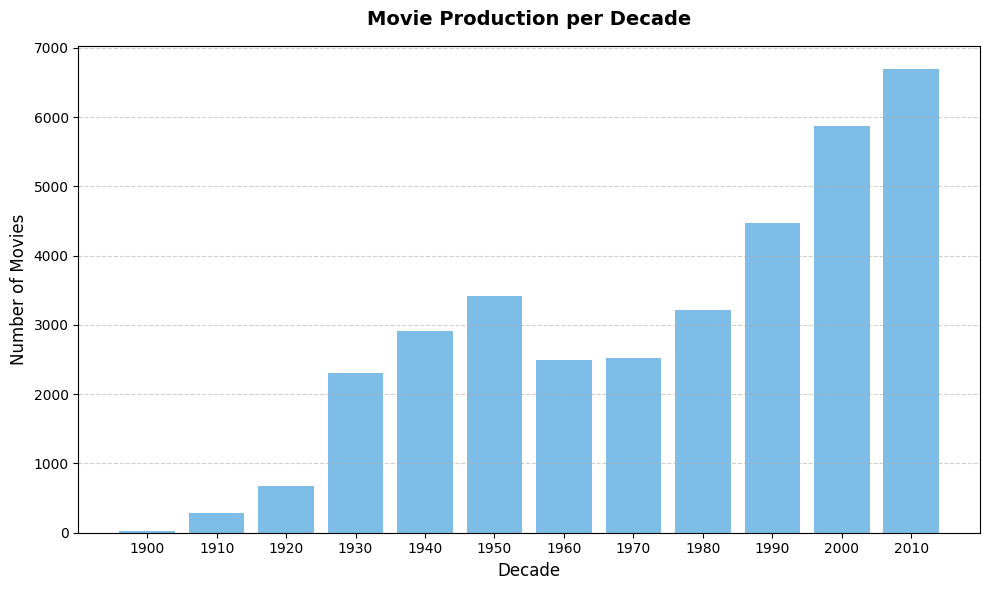

In [ ]:
df["Decade"] = (df["Release Year"] // 10) * 10
movies_per_decade = df["Decade"].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(movies_per_decade.index.astype(str), movies_per_decade.values, color="#5DADE2", alpha=0.8)

plt.title("Movie Production per Decade", fontsize=14, weight="bold", pad=15)
plt.xlabel("Decade", fontsize=12)
plt.ylabel("Number of Movies", fontsize=12)

plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

The distribution of movie releases per decade reveals a clear upward trend in film production throughout the 20th and early 21st centuries.  
After a modest output in the early decades of cinema (1900–1930), production expanded steadily, with sharp increases beginning in the 1990s and peaking in the 2000s and 2010s.  
This growth reflects the global expansion of the film industry, technological advances in digital production, and the democratization of filmmaking tools.  
No irregularities were observed in this variable that would require additional preprocessing.

**Title**

In [18]:
top_values_by_column(df, 'Title')


Column: Title
Title
The Three Musketeers       8
Cinderella                 8
Treasure Island            7
Anna Karenina              6
Alice in Wonderland        6
Hero                       6
Mother                     5
I Love You                 5
Criminal                   5
Madame X                   5
Angel                      5
Dr. Jekyll and Mr. Hyde    5
Dushman                    5
Love                       5
Cleopatra                  5
Kidnapped                  5
Robin Hood                 5
Brewster's Millions        5
Love Story                 4
Dracula                    4
Dressed to Kill            4
Night Watch                4
23                         4
Bad Company                4
Hide and Seek              4
Jigsaw                     4
Branded                    4
Romance                    4
Shikari                    4
Duniya                     4
Name: count, dtype: int64
--------------------------------------------------


While analyzing the *Title* column, it became evident that several movie titles appear multiple times, but with different release years — such as *The Three Musketeers*, *Cinderella*, and *Treasure Island*.  

These repetitions reflect remakes or adaptations, which is a valuable feature for Retrieval-Augmented Generation (RAG), as it enables the system to retrieve contextually related documents referring to the same story across different time periods.

In [19]:
df[df['Title'] == 'The Three Musketeers']

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,Decade
1998,1935,The Three Musketeers,American,Rowland V. Lee,"Paul Lukas, Walter Abel, Heather Angel","adventure, action",https://en.wikipedia.org/wiki/The_Three_Musketeers_(1935_film),"Callow youth d'Artagnan (Walter Abel) sets off from Gascony for Paris, armed with his father's sword, an old horse and a letter of introduction to his godfather, Captain de Treville (Lumsden Hare), commander of the King's Musketeers. Along the way, he attempts to rescue Milady de Winter (Margot Grahame) from highwaymen, but it turns out she came to meet their leader, the Count de Rochefort (Ian Keith). When Rochefort insults d'Artagnan, the latter insists on a duel. Instead, Rochefort has hi...",1930
4793,1948,The Three Musketeers,American,George Sidney,"Gene Kelly, Van Heflin, Lana Turner, June Allyson, Angela Lansbury",adventure,https://en.wikipedia.org/wiki/The_Three_Musketeers_(1948_film),"D'Artagnan (Gene Kelly), an inexperienced Gascon youth, travels to Paris to join the elite King's Musketeers. On his way, he encounters a mysterious lady at a roadside inn. When he picks a fight with one of her escorts, she becomes suspicious and has him knocked unconscious. His letter of introduction from his father to de Treville (Reginald Owen), the commander of the Musketeers, is burned. When he awakens, he continues on to the city.\r\nIn Paris, he nevertheless presents himself to de Tre...",1940
8988,1973,The Three Musketeers,American,Richard Lester,"Oliver Reed, Michael York, Richard Chamberlain, Raquel Welch",adventure,https://en.wikipedia.org/wiki/The_Three_Musketeers_(1973_film),"Having learned swordsmanship from his father, the young country bumpkin d'Artagnan arrives in Paris with dreams of becoming a king's musketeer. Unaccustomed to the city life, he makes a number of clumsy faux pas. First he finds himself insulted, knocked out and robbed by the Comte de Rochefort, an agent of Cardinal Richelieu, and once in Paris comes into conflict with three musketeers, Athos, Porthos, and Aramis, each of whom challenges him to a duel for some accidental insult or embarrassme...",1970
11911,1992,The Three Musketeers,American,Unknown,NaN,animated,https://en.wikipedia.org/wiki/The_Three_Musketeers_(1992_film),"The young D'Artagnan wants to be a musketeer and for this he travels the long way to the city of Paris in France, where he will enter the same academy for musketeers that his father had attended. On his way to Paris, however, he meets up with Monsieur Rochefort. D'Artagnan does not know that his rivalry with Monsieur Rochefort will get him involved in a battle against the evil plot thought up by Cardinal Richelieu against the king and queen of France. When Cardinal Richelieu discovers that t...",1990
12091,1993,The Three Musketeers,American,Stephen Herek,"Charlie Sheen, Kiefer Sutherland, Oliver Platt, Chris O'Donnell, Tim Curry, Rebecca De Mornay",adventure,https://en.wikipedia.org/wiki/The_Three_Musketeers_(1993_film),"In France, in 1625, d'Artagnan (Chris O'Donnell) sets off to Paris in hopes of becoming a member of the Musketeers, a band of men sworn to serve and protect the King of France, following in his late father's footsteps. d'Artagnan is pursued by Gérard and his brothers, who accuse him of blemishing their sister's honor. At Musketeer Headquarters, Captain Rochefort (Michael Wincott) and the Cardinal's Guards have disbanded the Musketeers as per the orders of Cardinal Richelieu (Tim Curry), the ...",1990
16131,2011,The Three Musketeers,American,Paul W. S. Anderson,"Logan Lerman, Milla Jovovich, Matthew Macfadyen, Ray Stevenson, Luke Evans, Mads Mikkelsen, Gabriella Wilde, James Corden, Juno Temple, Freddie Fox, Til Schweiger, Orlando Bloom, Christoph Waltz",action-adventure,https://en.wikipedia.org/wiki/The_Three_Musketeers_(2011_film),"In Venice, the musketeers Athos, Porthos, and Aramis, with the help of Milady de Winter, steal airship blueprints made by Leonardo d

Further inspection reveals that *The Three Musketeers (2011)* appears twice — one entry marked as *American* and another as *British*. This duplication may be caused by different metadata sources or slightly varying plot descriptions.

For RAG applications, preserving both records can be beneficial for contextual diversity, but they should be properly linked through identifiers such as title and release year to avoid redundant retrievals.

**Origin/Ethnicit**

In [20]:
top_values_by_column(df, 'Origin/Ethnicity')


Column: Origin/Ethnicity
Origin/Ethnicity
American        17377
British          3670
Bollywood        2931
Tamil            2599
Telugu           1311
Japanese         1188
Malayalam        1095
Hong Kong         791
Canadian          723
Australian        576
South_Korean      522
Chinese           463
Kannada           444
Bengali           306
Russian           232
Marathi           141
Filipino          128
Bangladeshi        87
Punjabi            84
Turkish            70
Malaysian          70
Egyptian           67
Assamese            9
Maldivian           2
Name: count, dtype: int64
--------------------------------------------------


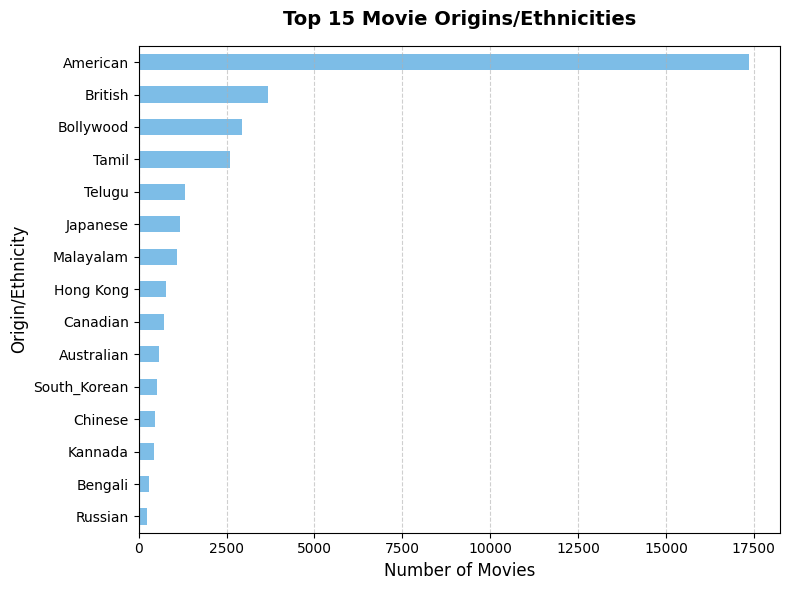

In [21]:
import matplotlib.pyplot as plt

top_origins = df["Origin/Ethnicity"].value_counts().head(15)

plt.figure(figsize=(8, 6))
top_origins.plot(kind="barh", color="#5DADE2", alpha=0.8)
plt.gca().invert_yaxis()  

plt.title("Top 15 Movie Origins/Ethnicities", fontsize=14, weight="bold", pad=15)
plt.xlabel("Number of Movies", fontsize=12)
plt.ylabel("Origin/Ethnicity", fontsize=12)
plt.grid(axis="x", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


**Director**

In [22]:
top_values_by_column(df, 'Director')


Column: Director
Director
Unknown               1124
Michael Curtiz          79
Hanna-Barbera           77
Lloyd Bacon             66
Jules White             63
John Ford               59
Allan Dwan              58
William A. Seiter       56
Norman Taurog           56
Richard Thorpe          55
Mervyn LeRoy            54
Raoul Walsh             53
Alfred Hitchcock        53
William Beaudine        52
Gordon Douglas          51
K. Raghavendra Rao      51
K. Balachander          50
Henry Hathaway          50
Alfred E. Green         50
George Marshall         49
Robert Z. Leonard       48
Roy Del Ruth            47
William A. Wellman      45
Lew Landers             44
Lesley Selander         44
Ray Enright             44
Cecil B. DeMille        44
Henry King              42
George Cukor            42
Arthur Lubin            42
Name: count, dtype: int64
--------------------------------------------------


**Cast**

In [23]:
top_values_by_column(df, 'Cast')


Column: Cast
Cast
nan                                                1422
Tom and Jerry                                        80
Three Stooges                                        56
The Three Stooges                                    47
Looney Tunes                                         37
Bugs Bunny                                           36
                                                     32
Abbott and Costello                                  17
Harold Lloyd                                         17
Buster Keaton                                        14
Drama                                                14
Arthur Lucan, Kitty McShane                          12
Basil Rathbone, Nigel Bruce                          10
Jackie Chan                                           9
Comedy                                                9
Mary Pickford                                         8
Leo Gorcey, Huntz Hall                                7
Stan Laurel, Oliver Hardy    

The `Cast` column contains a mixture of valid actor lists and inconsistent entries. Some records include valid cast members such as *“Tom and Jerry”* or *“Jackie Chan”*, while others contain non-cast values such as *“Drama”* and *“Comedy”*, or generic placeholders like *“Cast”*.  

In [24]:
df[df['Cast'] == 'Comedy']

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,Decade
80,1914,Charlie Chaplin,American,"Charlie Chaplin, Mabel Normand",Comedy,unknown,https://en.wikipedia.org/wiki/His_Trysting_Place,"Charlie and his friend Ambrose meet in a restaurant and accidentally leave with each other's coats. Charlie was going to pick up a baby bottle and Ambrose was going to mail a love letter that was in his coat pocket. Charlie's wife finds the letter and thinks he has a secret lover and Ambrose's wife believes he has an illegitimate child. Controversy arises in the park between Charlie and his wife and Ambrose and his wife. It is resolved at the end, but Charlie sparks another fight between the...",1910
23393,1995,Jeffrey Lau,Hong Kong,"Stephen Chow, Athena Chu, Ng Man-tat, Law Kar-ying, Jeffrey Lau, Yammie Lam, Karen Mok, Ada Choi",Comedy,duology,https://en.wikipedia.org/wiki/A_Chinese_Odyssey,"500 years ago, during their journey to the west to fetch the Buddhist scriptures, Monkey got annoyed with the constant nagging of his master, Longevity Monk, and decided to betray him. He was intercepted and subdued by Guanyin, who decided to give him a second chance after Longevity Monk pleaded for leniency and sacrificed himself.\r\nMonkey is reincarnated in the present as Joker, chief of a group of outlaws. Joker and his gang are attacked by two demons, Spider Woman and Bak Jing-jing, who...",1990
26307,2005,Ishaan Trvedi,Bollywood,"Juhi Chawla, Irfan Khan",Comedy,unknown,https://en.wikipedia.org/wiki/7%C2%BD_Phere,"After having tasted great success with soaps based on traditional families, a national TV network is getting into the next phase of programming - that is 'Reality TV' so they decide to go for the evergreen subject of marriages in Indian family. Channel asks their blue-eyed guy to produce the show. Asmi Ganatra (Juhi Chawla), the first time director, and her team finds out that at present the only family in Mumbai that meets the programming brief is Joshi's.\r\nJoshi's are stunned when Asmi v...",2000
26321,2005,Priyadarshan,Bollywood,"Akshay Kumar, John Abraham, Rimi Sen, Neha Dhupia",Comedy,unknown,https://en.wikipedia.org/wiki/Garam_Masala_(2005_film),"The film starts off when two photographers Makrand, aka Mac (Akshay Kumar) and Shyam, aka Sam (John Abraham) are doing a photo shoot. While Mac is shooting the models in exposing poses, his fiancée Anjali (Rimi Sen) leaves in disgust due to Mac's closeness to the models. Their boss calls them into his office and tells them that they are good-for-nothing photographers. He threatens to reduce their pay if they don't get some good pictures for the world photography competition to make his magaz...",2000
26323,2005,Sujoy Ghosh,Bollywood,"Vivek Oberoi, Mahima Chaudhry, Ayesha Takia",Comedy,unknown,https://en.wikipedia.org/wiki/Home_Delivery,"Home Delivery is the story of how it takes just a single day to change a person's outlook on life forever. Sunny Chopra (Vivek Oberoi) is a 28-year-old writer who has carved a name for himself as a popular agony uncle, named Gyan Guru, writing for the Times of Hindustan. Sunny also managed to bag a prestigious screenplay writing project for the most happening film director, Karan Johar. A bit of a cynic, he believes he is a self-made man and that whatever he has achieved in life is due to hi...",2000
26336,2005,Anees Bazmee,Bollywood,"Anil Kapoor, Salman Khan, Fardeen Khan, Bipasha Basu, Celina Jaitly, Esha Deol, Lara Dutta",Comedy,unknown,https://en.wikipedia.org/wiki/No_Entry,"Kishen (Anil Kapoor),a wealthy newspaper editor, has a suspicious-minded wife, Kaajal (Lara Dutta), who thinks he is always having an affair with another woman, even though he is extremely faithful to her and wouldn't dream of betraying her in any way. Prem (Salman Khan),Kishen's friend who is also a wealthy businessman, has the opposite situation. He is married to Pooja (Esha Deol), who is very trusting, even though he has been having several affairs with nume

During the inspection of the `Cast` column, some inconsistencies were identified. Some rows contain the value **"Comedy"**, which clearly represents a *genre* rather than a cast list.  
Conversely, the `Genre` column includes entries such as **"Panorama Studios"** and **"k9 films"**, which appear to be production companies rather than genre labels.

This pattern suggests that data from multiple columns may have been partially misaligned or shifted during the dataset’s compilation process. These inconsistencies indicate that certain rows have values incorrectly placed across the `Cast` and `Genre` fields.

Such findings are crucial for the data cleaning phase, where corrective transformations will be required to ensure that:
- `Cast` contains only actors, groups, or character names.
- `Genre` contains only valid genre descriptors (e.g., *Comedy*, *Drama*, *Action*, *Thriller*).

**Genre**

In [25]:
top_values_by_column(df, 'Genre', 50)


Column: Genre
Genre
unknown             6083
drama               5964
comedy              4379
horror              1167
action              1098
thriller             966
romance              923
western              865
crime                568
adventure            526
musical              467
crime drama          464
romantic comedy      461
science fiction      418
film noir            345
mystery              310
war                  273
animation            264
comedy, drama        236
sci-fi               221
family               217
fantasy              204
animated             195
musical comedy       154
comedy-drama         137
biography            136
anime                112
suspense             104
romantic drama       103
comedy drama         103
animated short        91
drama, romance        86
social                82
historical            77
documentary           73
action thriller       73
serial                71
world war ii          70
family drama          66
war 

The `Genre` column presents a well-defined set of valid categories, dominated by *drama*, *comedy* and *horror*. However, a closer inspection reveals several duplicated or semantically equivalent variations, such as *"comedy-drama"*, *"comedy, drama"*, and *"comedy/drama"*, which represent the same concept but appear as distinct values due to inconsistent formatting.

**Wiki Page**

In [26]:
top_values_by_column(df, 'Wiki Page')


Column: Wiki Page
Wiki Page
https://en.wikipedia.org/wiki/Himitsu_Sentai_Gorenger         5
https://en.wikipedia.org/wiki/Digimon_Adventure_tri.          5
https://en.wikipedia.org/wiki/Tamayura                        4
https://en.wikipedia.org/wiki/Mani_Malai                      4
https://en.wikipedia.org/wiki/Raasi                           3
https://en.wikipedia.org/wiki/123_(film)                      3
https://en.wikipedia.org/wiki/Eeram                           3
https://en.wikipedia.org/wiki/Shivamani                       3
https://en.wikipedia.org/wiki/Rechukka                        3
https://en.wikipedia.org/wiki/Room_(2015_film)                3
https://en.wikipedia.org/wiki/Mangalyam_(film)                3
https://en.wikipedia.org/wiki/Donga_Ramudu                    3
https://en.wikipedia.org/wiki/Free!_(anime)                   3
https://en.wikipedia.org/wiki/Mobile_Suit_Gundam              3
https://en.wikipedia.org/wiki/Chandirani                      3
https://en.

**Plot**

In [27]:
top_values_by_column(df, 'Plot', 30, 150)


Column: Plot
Plot
(マッスル人参争奪！超人大戦争, Massuru Ninjin Soudatsu! Choujin Dai Sensou)\r\nIn order to save a princess, Mantarou and the gang must find a special ginseng. They ar...    6
When world peace is threatened by the emergence of a terrorist group called the Black Cross Army, a peacekeeping organization called EAGLE (for Earth ...      5
The films take place three years after the events of Digimon Adventure 02 and focuses on the first season DigiDestined and their partner Digimon. A my...      5
The plot revolves around the players on a hockey team ("Les Boys") that play in a low level amateur hockey league. They are made up of a wide variety ...      4
Set in a fictional universe in the year 2179 (Universal Century year 0079 according to the Gundam Calendar), the Principality of Zeon has declared ind...      4
This film deals with untouchability in a lighter vein, about a bhagavathar (P. B. Rangachari) misbehaving with a domestic help (Jaya). She visits him ...      4
Tamayura center

In [28]:
# Find any row that contains the given text snippet
mask = df['Plot'].str.startswith("The story is about a New York gangster who is forced", na=False)

# Display the matching rows
df_filtered = df[mask]
display(df_filtered)


,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,Decade
11472,1990,Mob Story,American,Unknown,"John Vernon, Kate Vernon",drama,https://en.wikipedia.org/wiki/Mob_Story,The story is about a New York gangster who is forced to go on the run and hides out in the small town where he grew up.,1990
21885,1989,Mob Story,Canadian,"Gabriel Markiw, Jancarlo Markiw",Margot Kidder,crime drama,https://en.wikipedia.org/wiki/Mob_Story,The story is about a New York gangster who is forced to go on the run and hides out in the small town where he grew up.,1980
21898,1990,Mob Story,Canadian,Gabriel Markiw and Jancarlo Markiw,"John Vernon, Kate Vernon, Al Waxman",crime drama,https://en.wikipedia.org/wiki/Mob_Story,The story is about a New York gangster who is forced to go on the run and hides out in the small town where he grew up.,1990


Upon examining the Plot column, we identified a set of entries referring to the movie "`Mob Story`". Although all three records share **exactly the same plot summary**, the associated metadata presents **inconsistencies**.

Specifically, one record lists the movie as **American (1990)** with an **Unknown** director, while two others describe it as **Canadian (1989–1990)** directed by **Gabriel Markiw and Jancarlo Markiw**. Such discrepancies suggest a duplication issue or possible data merging between versions of the same film.

In [29]:
# Find any row that contains the given text snippet
mask = df['Plot'].str.startswith("Set in a fictional universe in the year 2179", na=False)

# Display the matching rows
df_filtered = df[mask]
display(df_filtered)


,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,Decade
33099,1981,Mobile Suit Gundam the Movie,Japanese,"Tomino, YoshiyukiYoshiyuki Tomino",NaN,unknown,https://en.wikipedia.org/wiki/Mobile_Suit_Gundam,"Set in a fictional universe in the year 2179 (Universal Century year 0079 according to the Gundam Calendar), the Principality of Zeon has declared independence from the Earth Federation, and subsequently launched a war of independence called the One Year War. The conflict has directly affected every continent on Earth, also nearly every space colony and lunar settlement. Zeon, though smaller, has the tactical upper hand through their use of a new type of humanoid weapons called mobile suits....",1980
33100,1981,Mobile Suit Gundam II: Soldiers of Sorrow,Japanese,"Tomino, YoshiyukiYoshiyuki Tomino",NaN,unknown,https://en.wikipedia.org/wiki/Mobile_Suit_Gundam,"Set in a fictional universe in the year 2179 (Universal Century year 0079 according to the Gundam Calendar), the Principality of Zeon has declared independence from the Earth Federation, and subsequently launched a war of independence called the One Year War. The conflict has directly affected every continent on Earth, also nearly every space colony and lunar settlement. Zeon, though smaller, has the tactical upper hand through their use of a new type of humanoid weapons called mobile suits....",1980
33103,1982,Mobile Suit Gundam: Encounters in Space,Japanese,Yoshiyuki Tomino,Tōru Furuya,unknown,https://en.wikipedia.org/wiki/Mobile_Suit_Gundam#Compilation_movies,"Set in a fictional universe in the year 2179 (Universal Century year 0079 according to the Gundam Calendar), the Principality of Zeon has declared independence from the Earth Federation, and subsequently launched a war of independence called the One Year War. The conflict has directly affected every continent on Earth, also nearly every space colony and lunar settlement. Zeon, though smaller, has the tactical upper hand through their use of a new type of humanoid weapons called mobile suits....",1980
33108,1982,Mobile Suit Gundam III: Encounter in Space,Japanese,Unknown,NaN,anime for children,https://en.wikipedia.org/wiki/Mobile_Suit_Gundam,"Set in a fictional universe in the year 2179 (Universal Century year 0079 according to the Gundam Calendar), the Principality of Zeon has declared independence from the Earth Federation, and subsequently launched a war of independence called the One Year War. The conflict has directly affected every continent on Earth, also nearly every space colony and lunar settlement. Zeon, though smaller, has the tactical upper hand through their use of a new type of humanoid weapons called mobile suits....",1980


Another relevant case involves the plot beginning with "*Set in a fictional universe in the year 2179 (Universal Century year 0079 according to the Gundam Calendar)*…". This exact description appears across several entries in the dataset, such as **"Mobile Suit Gundam the Movie" (1981)**, **"Mobile Suit Gundam II: Soldiers of Sorrow" (1981)**, and **"Mobile Suit Gundam: Encounters in Space" (1982)**.

Although these are distinct titles belonging to the Gundam cinematic universe, they share nearly identical plot summaries. From a data-quality perspective, this repetition does **not necessarily represent an error**. It reflects the narrative continuity of the franchise.

This situation is noteworthy for **RAG pipelines** because:
* Recurrent or duplicated narrative contexts can increase the number of nearly identical embeddings, potentially reducing retrieval diversity.
* Metadata variation across similar texts can influence the LLM's interpretation of context, especially when grounding relies on fields like release year or origin.